# NSBI diagnostics

In the previous chapter, we've trained CARL models that approximate the density ratio between two hypotheses of an event:

$$
 \hat{r}(x ; H_1, H_2) \sim r ( x ; H_1, H_2) \equiv \frac{p(x | H_1)}{p(x | H_2)}
$$

The validity of our NSBI results, of course, depends on close this approixmation, $~$, holds. We will perform two diagnostics to gauge how well our estimates are performing.

In [7]:
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
import vector
import hist

import sys
sys.path.append('../')
import torch
torch.set_float32_matmul_precision('medium')
from torch.utils.data import TensorDataset, DataLoader
import lightning as L

from physics.analysis import zz4l, zz2l2v
from datasets.balanced import BalancedDataset
from nsbi import carl

## 0. Load the training/validation data, scaler, and model checkpoint

First, we'll load everything we need. Note that if you set the same seed for the two models come into play, you only need to load denominator hypothesis datasets once; otherwise you will need the denominator datasets corresponding to each model separately.

In [8]:
run_dir = '/global/cfs/cdirs/trn016/carl_models'

(events_sig_train, events_sig_val), (events_bkg_train, events_bkg_val) = carl.utils.load_data(run_dir, 'sig_over_bkg')
(events_sbi_train, events_sbi_val), _ = carl.utils.load_data(run_dir, 'sbi_over_bkg')  # same seed!

scaler_sig_over_bkg, model_sig_over_bkg = carl.utils.load_results(run_dir, 'sig_over_bkg')
scaler_sbi_over_bkg, model_sbi_over_bkg = carl.utils.load_results(run_dir, 'sbi_over_bkg')

features_4l = ['l1_pt', 'l1_eta', 'l1_phi', 'l1_energy', 'l2_pt', 'l2_eta', 'l2_phi', 'l2_energy', 'l3_pt', 'l3_eta', 'l3_phi', 'l3_energy', 'l4_pt', 'l4_eta', 'l4_phi', 'l4_energy']


## 1. Expectation value

A fundamental property that a probability distribution function must satisfy is that its integral is $1$. In other words, the expectation value of any DRE over the denominator hypothesis must be that:

$$
\left< r(x ; N, D) \right>_{D} = \int dx \; \frac{p(x | N)}{\cancel{p(x | D)}} \; \cancel{p(x | D)} = 1.
$$

Let's explicitly verify this for each of the two DREs, $\rm S/B$ and $\rm SBI/B$, using the training data:

1. Scale the background events' features, $x$.
2. Obtain the classifier decisions, $\hat s(x)$, over the events.
3. Perform the likelihood trick over the output, $\hat r = \hat s/(1-\hat s)$.
4. Compute $C = \left< r \right>^{-1}_{\rm B}$.


In [62]:
def calibration_factor(dre, scaler, events_denom):
    """
    Evaluate the calibration factor of a DRE, i.e. inverse of its expectation value over denominator hypothesis.
    
    Parameters
    ----------
    dre : torch.nn.Module
        Trained DRE model (e.g. a CARL instance loaded from a checkpoint).
    events_denom : array-like or torch.Tensor
        Input events sampled from the denominator hypothesis distribution.
    scaler : sklearn.preprocessing.StandardScaler or similar
        Fitted scaler used to normalize the input features before passing them to the model.
    
    Returns
    -------
    torch.Tensor
        Model predictions for the density ratio evaluated on the input events.
    """
    # compute denominator hypothesis density
    p_denom = torch.tensor(events_denom.weights / events_denom.weights.sum())

    # run model over (scaled) denominator event inputs
    trainer = L.Trainer(accelerator='gpu', devices=1)    
    X_denom = scaler.transform(events_denom.kinematics[features_4l].to_numpy())
    dl_denom = DataLoader(TensorDataset(torch.tensor(X_denom, dtype=torch.float32)), batch_size=1024)
    s_num_vs_denom = torch.cat(trainer.predict(dre, dl_denom))

    # IMPLEMENT ME
    # likelihood ratio trick
    r_num_over_denom = s_num_vs_denom/(1-s_num_vs_denom)
    # inverse(!) of expectation value
    C_dre = 1.0/torch.sum(r_num_over_denom * p_denom)
    # ---

    return C_dre.numpy()

In [63]:
# IMPLEMENT ME
C_sig_over_bkg = calibration_factor(model_sig_over_bkg, scaler_sig_over_bkg, events_bkg_train)
C_sbi_over_bkg = calibration_factor(model_sbi_over_bkg, scaler_sbi_over_bkg, events_bkg_train)
print('C(S/B) = ', C_sig_over_bkg)
print('C(SBI/B) = ', C_sbi_over_bkg)
# ---

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
SLURM auto-requeueing enabled. Setting signal handlers.
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1658/1658 [00:06<00:00, 260.88it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
SLURM auto-requeueing enabled. Setting signal handlers.
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1658/1658 [00:06<00:00, 259.48it/s]
C(S/B) =  1.003374260021698
C(SBI/B) =  0.9994660228650708


As you might already have guessed, the inverse of the expectation value can be used as a *calibration factor* for the DRE as:

$$
\hat{r}_{\rm calib}(x) = C \times \hat{r} (x)
$$

So we should keep those numbers for later use! This procedure will ensure that the DRE is, on average, indeed corresponds to the ratio of probabilities. But note that this will not improve the accuracy of the DRE on a per-event basis, i.e. its variance.

This process can be considered to be still within "training" of the NN in the sense that (1) its purpose to improve its accuracy, and (2) we cannot perform this process over any testing data without any unblinding predjudice. Hence we perform this calibration over the denominator hypothesis events drawn from training data.


## 2. Reweighting

Another intuitive expectation of a DRE over the denominator hypothesis, this time on a per-event basis, is that it should provide a reweighting of the probability between hypotheses:

$$
 \hat{p}(x | H_1) = p(x| H_2) \times \hat{r}(x ; H_1, H_2) \Rightarrow \hat{w}_{H_1}(x) = w_{H_2}(x) \times r( x ; H_1, H_2) / N
$$

where $N$ is an arbitrary normalization factor (remember: we are performing a *density* ratio estimate!).
This time, let's perform this check using the *validation* data, we want to "evaluate" the performance of the NN independently of the training.

1. Evaluate the DRE over the denominator hypothesis event features following a similar procedure as above.
2. Multiply this over the denominator hypothesis event weights to estimate the numerator hypothesis weights.
3. Plot the original denominator hypothesis event distribution w.r.t. the $m_{4\ell}$ observable.
4. Plot the reweighted denominator-to-numerator hypothesis event distribution.
    - How significant of a shape change is this compared to #3?
5. Plot the distribution obtained directly from the numerator hypothesis.
    - Is the distribution #4 compatible, at least visually, with the correct answer?

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
SLURM auto-requeueing enabled. Setting signal handlers.
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 553/553 [00:02<00:00, 242.78it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
SLURM auto-requeueing enabled. Setting signal handlers.
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 553/553 [00:01<00:00, 279.07it/s]


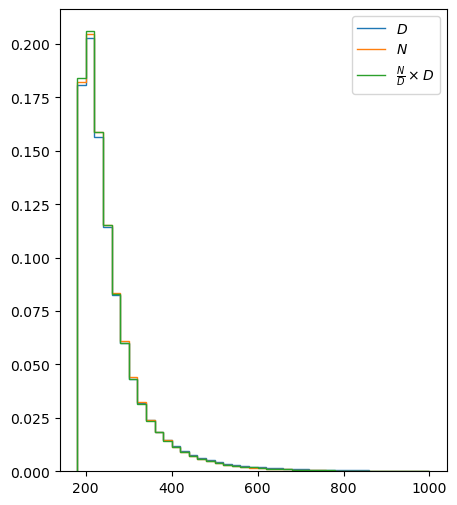

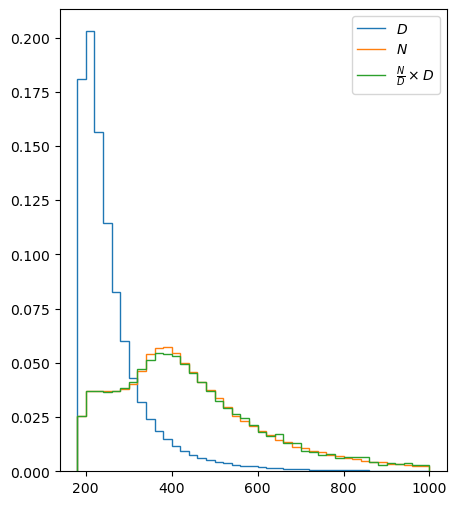

In [57]:
def reweighting_diagnostic(model, scaler, events_num_val, events_denom_val):
    # scale features
    X_denom_val = scaler.transform(events_denom_val.kinematics[features_4l].to_numpy())
    dl_denom_val = DataLoader(TensorDataset(torch.tensor(X_denom_val, dtype=torch.float32)), batch_size=1024) 
    
    # likelihood ratio trick
    trainer = L.Trainer(accelerator='gpu', devices=1)
    s_num_vs_denom = torch.cat(trainer.predict(model, dl_denom_val))
    r_num_over_denom = s_num_vs_denom / (1 - s_num_vs_denom)
    
    # histogram definition
    m4l_axis = hist.axis.Regular(41, 180, 1000, label = 'm4l')
    h_m4l_num = hist.Hist(m4l_axis)
    h_m4l_denom = hist.Hist(m4l_axis, label='$D$')
    h_m4l_num_from_denom = hist.Hist(m4l_axis, label='$D\\rightarrow N$')
    
    # observable calculation
    def calculate_m4l(kinematics):
        p_l1 = vector.array({'pt': kinematics['l1_pt'], 'eta': kinematics['l1_eta'], 'phi': kinematics['l1_phi'], 'energy': kinematics['l1_energy']})
        p_l2 = vector.array({'pt': kinematics['l2_pt'], 'eta': kinematics['l2_eta'], 'phi': kinematics['l2_phi'], 'energy': kinematics['l2_energy']})
        p_l3 = vector.array({'pt': kinematics['l3_pt'], 'eta': kinematics['l3_eta'], 'phi': kinematics['l3_phi'], 'energy': kinematics['l3_energy']})
        p_l4 = vector.array({'pt': kinematics['l4_pt'], 'eta': kinematics['l4_eta'], 'phi': kinematics['l4_phi'], 'energy': kinematics['l4_energy']})
        return (p_l1 + p_l2 + p_l3 + p_l4).mass
    
    # weights
    w_denom = torch.tensor(events_denom_val.weights)
    w_num = torch.tensor(events_num_val.weights)
    # IMPLEMENT ME
    w_num_from_denom = torch.tensor(events_denom_val.weights) * r_num_over_denom
    # ---
    
    # normalize to weights probablity
    p_denom = w_denom / torch.sum(w_denom)
    p_num = w_num / torch.sum(w_num)
    p_num_from_denom = w_num_from_denom / torch.sum(w_num_from_denom)
    
    # populate each histogram with correct (obs, w)
    # IMPLEMENT ME
    h_m4l_denom.fill( calculate_m4l(events_denom_val.kinematics), weight=p_denom)
    h_m4l_num.fill( calculate_m4l(events_num_val.kinematics), weight=p_num)
    h_m4l_num_from_denom.fill( calculate_m4l(events_denom_val.kinematics), weight=p_num_from_denom)
    # ---
    
    # plotting
    fig = plt.figure(figsize=(6, 5))
    plt.stairs(h_m4l_denom.values(), h_m4l_denom.axes[0].edges, label='$D$')
    plt.stairs(h_m4l_num.values(), h_m4l_num.axes[0].edges, label='$N$')
    plt.stairs(h_m4l_num_from_denom.values(), h_m4l_num_from_denom.axes[0].edges, label='$\\frac{N}{D} \\times D$')
    plt.legend()
    
reweighting_diagnostic(model_sbi_over_bkg, scaler_sbi_over_bkg, events_sbi_val, events_bkg_val)
reweighting_diagnostic(model_sig_over_bkg, scaler_sig_over_bkg, events_sig_val, events_bkg_val)

As performed in Chapter 1, you are encouraged to check in more detail via ratio plots.

## 3. Calibration curve

In section 2, we've checked qualitatively the accuracy of our DRE w.r.t. *one* projection of our observable space, $m_{4\ell}$. 
In principle, we could obtain an improved calibration function, e.g. $C(m_{4\ell})$.
But what about the other 15 variables? This is probably not feasible without training data that is several orders of magnitude larger...

There is an alternative, feasible, and more systematic way to assess the per-event accuracy of our DREs.
First, consider examples drawn from the numerator & denominator hypothesis, drawn in a balanced way & labelled $y_i = 0,1$ exactly as we did for training our DREs in the first place.
Then, running our classifier over this dataset yields the pre-likelihood ratio trick decision:
$$
    \hat s( x ; N, D) \sim \frac{p_N(x)}{p_N(x) + p_D(x)}
$$
For each sub-population of events of a specific (or some range of) $\hat s$ value, there will be a mixture of (again, labelled) events have have been drawn from the numerator or denominator hypotheses, which can be directly counted.
Computing the relative yield of the numerator events over the total then yields an "MC estimate" of the true probability ratio.
This is referred to as the _calibration_ curve of the DRE.


as an unbiased function of $x$. We can check if this is satisfied by performing the following:

1. Bin events sampled from the numerator & denominator hypotheses according the classifier estimate, $\hat s$.
    - IMPORTANT: Remember to apply the calibration factor, $C$, from above!
3. Obtain distributions, i.e. histograms, of the classifier decision weighted by the (balanced) event weights.
    - IMPORTANT: One each for numerator & denominator hypothesis events, identified by $y=1,0$!
4. Use the histograms to compute the MC estimate in each bin, $s = \frac{N(y=1)}{N(y=0) + N(y=1)}$.

### 3.(a) Running the model over the numerator & denominator hypothesis datasets

We will make use of the pre-available `BalancedDataset` implementation (which was also used in the training) to consistently perform the $x$-scaling, event weight balancing, and $y = 0,1$ labeling of the numerator & denominator hypotheses.


<>:56: SyntaxWarning: invalid escape sequence '\h'
<>:56: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1316281/3200969042.py:56: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("NSBI estimate, $\hat{s}(x)$")
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
SLURM auto-requeueing enabled. Setting signal handlers.
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2547/2547 [00:07<00:00, 360.48it/s]


/tmp/ipykernel_1316281/3200969042.py:51: RuntimeWarning: invalid value encountered in divide
  s_mc_val = N / (N + D)
/tmp/ipykernel_1316281/3200969042.py:52: RuntimeWarning: invalid value encountered in divide
  s_mc_err = np.sqrt((D / np.square(N + D))**2 * VN + (N / np.square(N + D))**2 * VD)
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
SLURM auto-requeueing enabled. Setting signal handlers.
/global/common/software/trn016/python_envs/ml4fp2025Day2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 3346/3346 [00:09<00:00, 362.27it/s]


/tmp/ipykernel_1316281/3200969042.py:51: RuntimeWarning: invalid value encountered in divide
  s_mc_val = N / (N + D)
/tmp/ipykernel_1316281/3200969042.py:52: RuntimeWarning: invalid value encountered in divide
  s_mc_err = np.sqrt((D / np.square(N + D))**2 * VN + (N / np.square(N + D))**2 * VD)


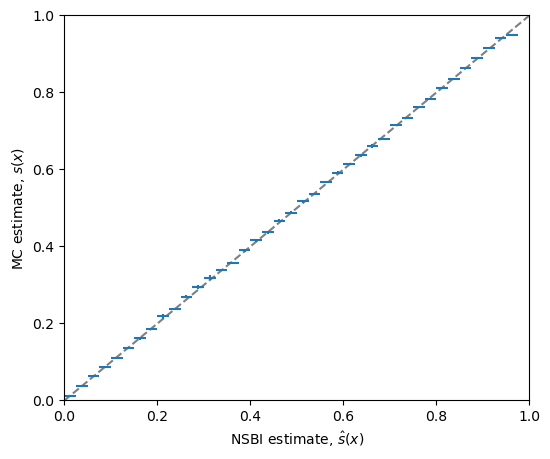

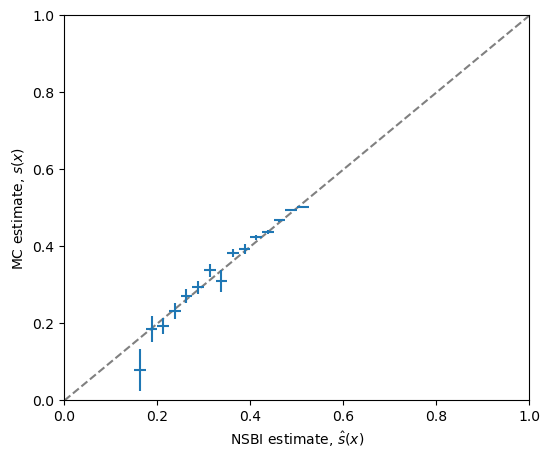

In [65]:
# IMPLEMENT ME
def calibration_curve(model, scaler, events_num, events_denom, calibration_factor):
    """
    Obtain calibration curve, C(x) of a DRE
    Parameters
    ---
    model: DRE model
    scaler: feature scaler
    events_num: numerator hypothesis events
    events_denom: denominator hypothesis events
    calibration_factor: overall calibration factor from expectation value
    """

    # classifier decision
    ds_balanced = BalancedDataset(events_num, events_denom, features=features_4l, scaler=scaler)
    dl = torch.utils.data.DataLoader(torch.tensor(ds_balanced.X, dtype=torch.float32), batch_size=1024)
    s_num_vs_denom = torch.cat(trainer.predict(model, dl)).detach().numpy()

    # likelihood ratio trick -> apply calibration factor -> (lhrt)^(-1)
    # IMPLEMENT ME
    r_num_over_denom = s_num_vs_denom/(1-s_num_vs_denom)
    r_num_over_denom * calibration_factor
    s_num_vs_denom = r_num_over_denom / (1+r_num_over_denom)
    # ---
    
    # (balanced) event weight?
    w_balanced = ds_balanced.w
    
    # true label (1 = numerator, 0 = denominator)
    y_num_or_denom = ds_balanced.s

    # s binning & histograms
    s_bins = np.linspace(0.0, 1.0, 41)
    s_centers = (s_bins[:-1] + s_bins[1:])/2
    s_nbins = len(s_bins) -1
    s_widths = (s_bins[1:] - s_bins[:-1])/2
    s_axis = hist.axis.Regular(40,0,1.0)
    h_num, h_denom = hist.Hist(s_axis, storage=hist.storage.Weight()), hist.Hist(s_axis, storage=hist.storage.Weight())

    # histogram using DRE as observable using balanced weights
    # select only events with the correct labels for num & denom hypo's!
    # IMPLEMENT ME
    h_num.fill(s_num_vs_denom[y_num_or_denom==1], weight = w_balanced[y_num_or_denom==1])
    h_denom.fill(s_num_vs_denom[y_num_or_denom==0], weight = w_balanced[y_num_or_denom==0])
    # ---
    
    N = h_num.values()
    D = h_denom.values()
    VN = h_num.variances()
    VD = h_denom.variances()
    s_mc_val = N / (N + D)
    s_mc_err = np.sqrt((D / np.square(N + D))**2 * VN + (N / np.square(N + D))**2 * VD)
    
    fig = plt.figure(figsize=(6,5))
    plt.plot([0,1], [0,1], marker='none', linestyle='--', color='grey')
    plt.xlabel("NSBI estimate, $\hat{s}(x)$")
    plt.ylabel("MC estimate, $s(x)$")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.errorbar(s_centers, s_mc_val, xerr=s_widths, yerr=s_mc_err, linestyle='none')

calibration_curve(model_sig_over_bkg, scaler_sig_over_bkg, events_sig_train, events_bkg_train, C_sig_over_bkg)
calibration_curve(model_sbi_over_bkg, scaler_sbi_over_bkg, events_sbi_train, events_bkg_train, C_sbi_over_bkg)

- How do the calibration curve look? Is it close to a diagonal line?
- What do you notice about the range & variance of the curves between the two DREs? Why do you think such differences come about?


### 3.(f) Extra: remarks on "MC estimate"

The calibration curve is a function of the DRE output values, $\hat s(x)$. You may wonder: 
- Why did we have to bother with calculating an "MC estimate" of the true density ratio, $s(x)$?
- In fact, why did we not simply evaluate the accuracy of $\hat s(x)$  as a function of $s(x)$?
The answer to this question lies in recognizing that $s(x)$, i.e. the density ratio as a function of observables, is an *intractable* quantity as mentioned previously and the motivation for NSBI in the first place.

### 3.(g) Extra: from calibration factor to function

Extra: The calibration curve is useful in the sense that now we can quantitavely evaluate how (in)accurate our network predictions are as a function of its input variables. Mathematically speaking, as long as the curve obtained above is _monotonic_, one can in principle derive a calibration function, $C(x)$,

$$
C(x) \times \left< \hat{s}(x) \right> = \left< s(x) \right>
$$,

where $C(x)$ is now a per-event function, as opposed to a global factor from the expectation value approach! For the next chapter we will assume that this calibration is perfect; the next tutorial on ensembling will allow us to get a handle on additional uncertainties that should be accounted for due to statistical sources including this model mis-specification.